In [3]:
# waveform sandbox 
waveform_data = {}
waveform_data["Header"]={}
waveform_data["Parameters"]={}
waveform_data["Data"]=[]
currSection = ""
with open(filepath) as f:
    data = f.readlines()
    for dline in data:
        sectionChanged = False
        # know the current section
        for sec in ["Header","Parameters","Data"]:
            if dline.find(sec) != -1:
                currSection = sec
                sectionChanged = True 
        if sectionChanged:
            continue 
            
        dline = dline.strip()
        if (currSection=="Header" or currSection=="Parameters") and len(dline)>1:
            keyval = dline.split("=")
            if keyval[1][0].isdigit():
                keyval[1] = float(keyval[1])
            waveform_data[currSection][keyval[0]] = keyval[1]
        elif currSection=="Data" and len(dline)>1:
            waveform_data[currSection].append(float(dline))
    

In [4]:
filepath = "Waveform/ATS26/26%02d.wf"%((14))
print filepath

Waveform/ATS26/2614.wf


In [5]:
str(waveform_data["Parameters"])

"{'PEF': 3.821, 'FEV1': 2.249}"

In [7]:
# from scikits.talkbox import lpc

In [8]:
import numpy as np
np.__version__

'1.10.4'

In [9]:
import scipy.io.wavfile as wavfile
from scipy.signal import *
from scipy import optimize
import sys
from matplotlib.pyplot import specgram
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
fs, x = wavfile.read("../audio_curve_data/1459402052.121259.wav")
fs, x = wavfile.read("../audio_curve_data/1459459269.076375.wav")
fs, x = wavfile.read("../audio_curve_data/1459460426.952584.wav")

/Library/Python/2.7/site-packages/scipy/io/wavfile.py:221: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


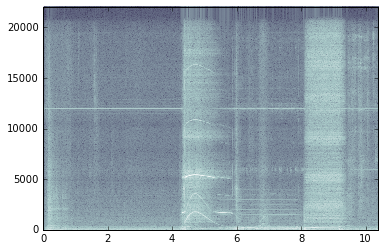

In [10]:
P_skip = 128
P_NFFT = 2048
P,P_f,P_t,im = specgram(x, NFFT=P_NFFT, Fs=fs, noverlap=P_NFFT-P_skip, window=np.hamming(P_NFFT))
P = P.astype(np.float)
durationOfRecording = P_t[-1]

ax = plt.subplot(111)
ax.pcolorfast(P_t, P_f, 10 * np.log10(P),cmap=plt.cm.bone)

In [11]:
X_inv = .5*np.array([
    [1, -2, 1],
    [-1, 0, 1],
    #[0, 2, 0]
])

def cubic_peak_interpolation(P_slice):
    # Get the peak index
    peak_idx = min(max(np.argmax(P_slice),1), len(P_slice)-2)

    # Now perform cubic interpolation to get sub-bin accuracy (we assume the peak is never the first or last index)
    Z = np.dot(X_inv, P_slice[peak_idx-1:peak_idx+2])

    # We now have the a and b coefficients of the parabola (we disregard c), so we find peak offset
    # and use that to get sub-bin accuracy:
    return peak_idx - Z[1]/(2*Z[0])

# Weigh lower frequencies better
def decreasing_windowed_fft_analysis(P, sigma=10.0, lowweight=.9, fs=2):
    max_idx = np.unravel_index(np.argmax(P), P.shape)

    # Step forward and backward
    fft_f = np.zeros((P.shape[1],))
    fft_f[max_idx[1]] = max_idx[0]
    for t in xrange(max_idx[1]+1, P.shape[1]):
        # Build an appropriate window centered on fft_f[t-1]
        window = np.exp(-(fft_f[t-1]*lowweight - np.arange(P.shape[0]))**2/sigma**2)

        fft_f[t] = cubic_peak_interpolation(P[:,t]*window)

    for t in xrange(max_idx[1]-1, 0, -1):
        # Build an appropriate window centered on fft_f[t+1]
        window = np.exp(-(fft_f[t+1]*lowweight - np.arange(P.shape[0]))**2/sigma**2)

        fft_f[t] = cubic_peak_interpolation(P[:,t]*window)

    return fft_f*fs/(2*P.shape[0])

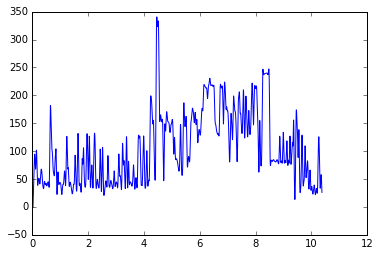

In [12]:
P_max = decreasing_windowed_fft_analysis(P[:70,:], fs=fs)*70/P.shape[0]
b, a = butter(3, .1, btype='low')
P_max = filtfilt(b, a, P_max)

P_argmax = np.int_(P_max*P_NFFT/fs)
P_weights = np.array([P[P_argmax[t],t] for t in xrange(P.shape[1])])**2
plt.plot(P_t, P_max)

In [13]:
from skimage import morphology as mp

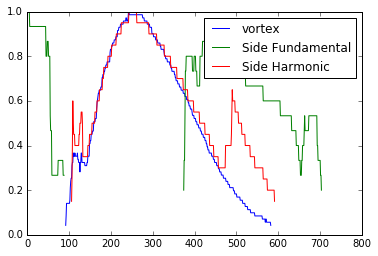

In [14]:
# def follow_peak_in_band(band,time_energy):
    
#     PEF_index = np.argmax(time_energy)
#     print np.argmax(band[:,PEF_index])
    
#     band = (band - np.min(band)) / (np.max(band)-np.min(band))*255
#     band = band.astype(np.uint8)
#     b_dilate = mp.dilation(band,np.matrix(np.ones((5,1))).astype(np.uint8))

#     # P_local_max = mp.binary_dilation(P_dilate==P_normalized,mp.disk(1)) & (P_normalized>190)
#     mask = np.repeat((time_energy>np.mean(time_energy)*0.1),band.shape[0], axis=0).reshape(band.T.shape).T
#     mask = mp.binary_closing(mask,np.ones((1,10)))
#     mask = mp.binary_erosion(mask,np.ones((1,10)))
#     b_local_max = (b_dilate==band) & (band>150) & mask

#     b_local_max = mp.binary_closing(b_local_max,np.eye(3))
#     b_local_max = mp.binary_closing(b_local_max,np.eye(3).T)
#     #P_local_max = mp.skeletonize(P_local_max)
#     b_local_max = b_local_max.astype(np.bool)
#     #b_local_max = mp.remove_small_objects(b_local_max, min_size = 10, connectivity=13, in_place=True)
#     return b_local_max

def inward_peak_in_band(band,time_energy,cooling,strtpt):
    
    band = (band - np.min(band)) / (np.max(band)-np.min(band))*255
    
    #b_index = np.argmax(time_energy)
    
    time_energy_first = np.sum(band[:,:strtpt],axis=0)
    b_index = np.argmax(time_energy_first)
    strt_idx = np.argmax(band[:,b_index])

    b_local_max = np.zeros(band.shape).astype(np.bool)
    x = [strt_idx,b_index]
    b_local_max[x[0],x[1]] = 1
    wind_down = 4
    wind_up = 2
    traj = np.nan
    cooling_iter = 1
    for i in range(x[1],len(time_energy)):
        freqs = band[x[0]-wind_down:x[0]+wind_up,i]
        if len(freqs)>0:
            j = np.argmax(freqs)
            
            # get possible new point
            new_point = x[0]-wind_down+j
            # get trajectory of last move
            tmp_traj = float(x[0])-new_point
            
            if np.isnan(traj):
                traj = tmp_traj
            # average trajectory with new
            traj = (cooling*tmp_traj+(1-cooling)*traj)
            new_point = int(x[0]-traj)
            
            b_local_max[new_point,i]=1
            
            x[0] = new_point

        
    x = [strt_idx,b_index]
    traj = np.nan
    for i in range(x[1],0,-1):
        freqs = band[x[0]-wind_down:x[0]+wind_up,i]
        if len(freqs)>0:
            j = np.argmax(freqs)
            
            # get possible new point
            new_point = x[0]-wind_down+j
            # get trajectory of last move
            tmp_traj = float(x[0])-new_point
            if np.isnan(traj):
                traj = tmp_traj
            # average trajectory with new
            traj = (cooling*tmp_traj+(1-cooling)*traj)
            new_point = int(x[0]-traj)
            
            b_local_max[new_point,i]=1
            
            x[0] = new_point
    all_arg_max = np.zeros(time_energy.shape)
    for i in range(all_arg_max.shape[0]):
        all_arg_max[i] = np.argmax(b_local_max[:,i])
    
    return b_local_max, all_arg_max

def outward_peak_in_band(band,time_energy,cooling,strtpt):
    
    band = (band - np.min(band)) / (np.max(band)-np.min(band))*255
    
    #b_index = np.argmax(time_energy)+150
    
    time_energy_first = np.sum(band[:,strtpt:],axis=0)
    b_index = np.argmax(time_energy_first)+strtpt
    strt_idx = np.argmax(band[:,b_index])

    b_local_max = np.zeros(band.shape).astype(np.bool)
    x = [strt_idx,b_index]
    b_local_max[x[0],x[1]] = 1
    wind_down = 4
    wind_up = 2
    traj = np.nan
    cooling_iter = 1
    for i in range(x[1],len(time_energy)):
        freqs = band[x[0]-wind_down:x[0]+wind_up,i]
        if len(freqs)>0:
            j = np.argmax(freqs)
            
            # get possible new point
            new_point = x[0]-wind_down+j
            # get trajectory of last move
            tmp_traj = float(x[0])-new_point
            
            if np.isnan(traj):
                traj = tmp_traj
            # average trajectory with new
            traj = (cooling*tmp_traj+(1-cooling)*traj)
            new_point = int(x[0]-traj)
            
            b_local_max[new_point,i]=1
            
            x[0] = new_point

        
    x = [strt_idx,b_index]
    traj = np.nan
    for i in range(x[1],0,-1):
        freqs = band[x[0]-wind_down:x[0]+wind_up,i]
        if len(freqs)>0:
            j = np.argmax(freqs)
            
            # get possible new point
            new_point = x[0]-wind_down+j
            # get trajectory of last move
            tmp_traj = float(x[0])-new_point
            if np.isnan(traj):
                traj = tmp_traj
            # average trajectory with new
            traj = (cooling*tmp_traj+(1-cooling)*traj)
            new_point = int(x[0]-traj)
            
            b_local_max[new_point,i]=1
            
            x[0] = new_point
    all_arg_max = np.zeros(time_energy.shape)
    for i in range(all_arg_max.shape[0]):
        all_arg_max[i] = np.argmax(b_local_max[:,i])
    
    return b_local_max, all_arg_max

def follow_peak_in_band(band,time_energy,cooling,b_index):
    
    band = (band - np.min(band)) / (np.max(band)-np.min(band))*255
    
    b_index = np.argmax(time_energy)
    strt_idx = np.argmax(band[:,b_index])

    b_local_max = np.zeros(band.shape).astype(np.bool)
    x = [strt_idx,b_index]
    b_local_max[x[0],x[1]] = 1
    wind_down = 4
    wind_up = 4
    traj = np.nan
    cooling_iter = 1
    for i in range(x[1],len(time_energy)):
        freqs = band[x[0]-wind_down:x[0]+wind_up,i]
        if len(freqs)>0:
            j = np.argmax(freqs)
            
            # get possible new point
            new_point = x[0]-wind_down+j
            # get trajectory of last move
            tmp_traj = float(x[0])-new_point
            
            if np.isnan(traj):
                traj = tmp_traj
            # average trajectory with new
            traj = (cooling*tmp_traj+(1-cooling)*traj)
            new_point = int(x[0]-traj)
            
            b_local_max[new_point,i]=1
            
            x[0] = new_point

        
    x = [strt_idx,b_index]
    traj = np.nan
    for i in range(x[1],0,-1):
        freqs = band[x[0]-wind_down:x[0]+wind_up,i]
        if len(freqs)>0:
            j = np.argmax(freqs)
            
            # get possible new point
            new_point = x[0]-wind_down+j
            # get trajectory of last move
            tmp_traj = float(x[0])-new_point
            if np.isnan(traj):
                traj = tmp_traj
            # average trajectory with new
            traj = (cooling*tmp_traj+(1-cooling)*traj)
            new_point = int(x[0]-traj)
            
            b_local_max[new_point,i]=1
            
            x[0] = new_point
    all_arg_max = np.zeros(time_energy.shape)
    for i in range(all_arg_max.shape[0]):
        all_arg_max[i] = np.argmax(b_local_max[:,i])
    
    return b_local_max, all_arg_max

energy = np.sum(P, axis=0)
energy = energy*(fs/2)/np.max(energy)
energy_log = np.sum(np.log(P), axis=0)
energy_log = energy_log-np.min(energy_log)
energy_log = energy_log*(fs/2)/np.max(energy_log)

# likely place that PEF occurs
tpeak_idx = np.argmax(energy)
tpeak_left = max((tpeak_idx-80,0))
tpeak_right = min((tpeak_idx+80,P.shape[1]))
PEF_index = np.argmax(P_max[tpeak_left:tpeak_right]) + tpeak_left
PEF_index

fs_effective = fs/P_skip
time_before_PEF = fs_effective/2 
 
time_after = fs_effective*3
energy = energy[PEF_index-time_before_PEF:PEF_index+time_after]
energy_log = energy_log[PEF_index-time_before_PEF:PEF_index+time_after]

#==================vortex range===============
min_f_a = 275
max_f_a = 2200
P_vortex = np.log(P[(P_f>min_f_a) &(P_f<max_f_a),PEF_index-time_before_PEF:PEF_index+time_after])
P_vortex_max, vortex_freq = follow_peak_in_band(P_vortex,energy,1.0,time_before_PEF)


vortex_freq = vortex_freq*fs/P_NFFT
vortex_freq = (vortex_freq-np.min(vortex_freq))/(np.max(vortex_freq)-np.min(vortex_freq))
vortex_freq[vortex_freq==0]=np.nan
# vortex_freq[vortex_freq==min_f_a]=0

plt.plot(vortex_freq,label='vortex')

#==================side whistle low===============
min_f_a = 1500
max_f_a = 2000
P_s_low = np.log(P[(P_f>min_f_a) &(P_f<max_f_a),PEF_index-time_before_PEF:PEF_index+time_after])
# P_s_low_max, s_low_freq = follow_peak_in_band(P_s_low,energy,1.0,time_before_PEF)
first = np.nan
second = np.nan
for i in range(len(vortex_freq)):
    if np.isnan(vortex_freq[i]) and np.isnan(first):
        first = i
        
    if not np.isnan(vortex_freq[i]):
        second = i
        
P_s_low_max1, s_low_freq1 = inward_peak_in_band(P_s_low,energy,1.0,first+20)
P_s_low_max2, s_low_freq2 = outward_peak_in_band(P_s_low,energy,1.0,second-20)
P_s_low_max = P_s_low_max1 | P_s_low_max2

s_low_freq = np.zeros(s_low_freq1.shape)
for i in range(s_low_freq1.shape[0]):
    s_low_freq[i] = np.argmax(P_s_low_max[:,i])

s_low_freq = s_low_freq*fs/P_NFFT
s_low_freq = s_low_freq/np.max(s_low_freq)
s_low_freq[s_low_freq==0]=np.nan
# s_low_freq[s_low_freq==min_f_a]=0

plt.plot(s_low_freq,label='Side Fundamental')

#==================side whistle high===============
min_f_a = 5000
max_f_a = 5500
P_s_hi = np.log(P[(P_f>min_f_a) &(P_f<max_f_a),PEF_index-time_before_PEF:PEF_index+time_after])
P_s_hi_max, s_hi_freq = follow_peak_in_band(P_s_hi,energy,1.0,time_before_PEF)

s_hi_freq = s_hi_freq*fs/P_NFFT+min_f_a
s_hi_freq = (s_hi_freq-np.min(s_hi_freq))/(np.max(s_hi_freq)-np.min(s_hi_freq))
s_hi_freq[s_hi_freq==0]=np.nan

plt.plot(s_hi_freq,label='Side Harmonic')


plt.legend()
plt.show()

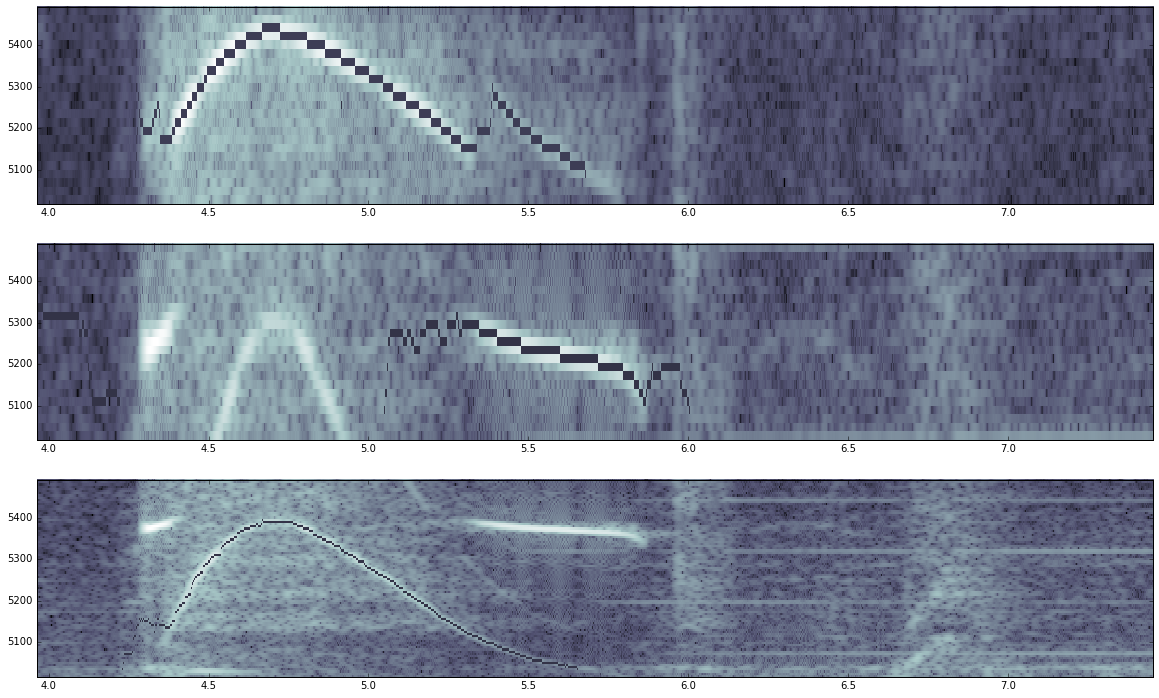

In [15]:
plt.figure(figsize=(20,12))
ax = plt.subplot(3,1,3)
Ptmp = P_vortex.copy()
Ptmp[P_vortex_max==True] = -5
ax.pcolorfast(P_t[PEF_index-time_before_PEF:PEF_index+time_after], P_f[(P_f>min_f_a) &(P_f<max_f_a)], Ptmp, cmap=plt.cm.bone)

ax = plt.subplot(3,1,2)
Ptmp = P_s_low.copy()
Ptmp[P_s_low_max==True] = -5
ax.pcolorfast(P_t[PEF_index-time_before_PEF:PEF_index+time_after], P_f[(P_f>min_f_a) &(P_f<max_f_a)], Ptmp, cmap=plt.cm.bone)

ax = plt.subplot(3,1,1)
Ptmp = P_s_hi.copy()
Ptmp[P_s_hi_max==True] = -5
ax.pcolorfast(P_t[PEF_index-time_before_PEF:PEF_index+time_after], P_f[(P_f>min_f_a) &(P_f<max_f_a)], Ptmp, cmap=plt.cm.bone)

plt.show()

In [17]:
# print np.sum(P_local_max)

# PEF_fft_frame = P[:,PEF_index]
# plt.plot(P_f,np.log(PEF_fft_frame))

In [19]:
# plt.figure(figsize=(10,10))
# ax = plt.subplot(111)
# ax.pcolorfast(P_t, P_f, P_dilate)
# plt.show()

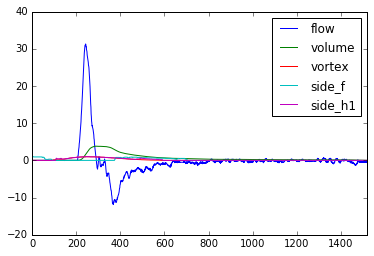

In [21]:
import pandas as pd

v = np.array(waveform_data["Data"]).astype(np.float)
fs_w = float(waveform_data["Header"]['Freq'])
f = (v[1:]-v[:-1])*fs_w
f = np.hstack(([0],f))

x1 = vortex_freq
x2 = s_low_freq
x3 = s_hi_freq

# make same sampling rate
f = resample(f,len(f)/fs_w*fs_effective)

x1[np.isnan(x1)] = 0
x2[np.isnan(x2)] = 0
x3[np.isnan(x3)] = 0

x1_m = np.argmax(x1)
f_m = np.argmax(f)

# align maxima
if x1_m>f_m:
    f = np.hstack((np.zeros((x1_m-f_m,)),f))
else:
    x1 = np.hstack((np.zeros((f_m-x1_m,)),x1))
    x2 = np.hstack((np.zeros((f_m-x1_m,)),x2))
    x3 = np.hstack((np.zeros((f_m-x1_m,)),x3))
    
# make equal lengths
if len(x1)>len(f):
    f = np.hstack((f,np.zeros((len(x1)-len(f),))))
else:
    x1 = np.hstack((x1,np.zeros((len(f)-len(x1),))))
    x2 = np.hstack((x2,np.zeros((len(f)-len(x2),))))
    x3 = np.hstack((x3,np.zeros((len(f)-len(x3),))))
    
v = np.cumsum(f/fs_effective)
df = pd.DataFrame(np.vstack((f,v,x1,x2,x3)).T,columns=['flow','volume','vortex','side_f','side_h1'])

df.plot()

In [22]:
df.head()

,flow,volume,vortex,side_f,side_h1
0,0,0,0,0,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


In [24]:
# mask = np.repeat((energy>np.mean(energy)*0.1),P.shape[0], axis=0).reshape(P.T.shape).T
# mask = mp.binary_closing(mask,np.ones((1,100)))
# plt.pcolormesh(P_t, P_f, mask,cmap=plt.cm.bone)

In [25]:
def create_custom_wf(PEF,name):

    import numpy as np
    from matplotlib import pyplot as plt
    %matplotlib inline

    fs = 100
    with open('%s.wf'%(name),'w') as f:
        f.write('[Header]\n')
        f.write('Group=OpenSpiro\nName=%s\nType=FT\nFreq=%d\nExpStart=0\n\n'%((name,fs)))
        
        FVC = 20
        numpoints = 1000
        while FVC > 9.9999:
            numpoints = numpoints-5
            data = np.linspace(0,PEF,numpoints)
            data = np.hstack((data,np.ones((int(fs/5)))*PEF,data[::-1]))
            FVC = np.sum(data/float(fs))

        f.write('[Parameters]\nPEF=%.4f\nFVC=%.4f\n\n[Data]\n'%((PEF,FVC)))
        for num in data:
            f.write('%.4f\n'%(num))

    print PEF, FVC, len(data)/float(fs)
    plt.plot(np.array(range(len(data)))/float(fs),data)
    plt.show()

1.0 9.95 19.7


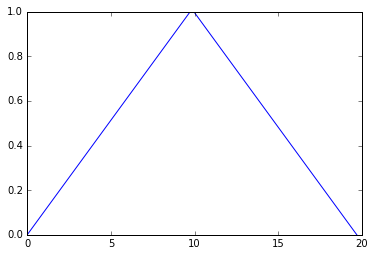

2.0 9.9 9.7


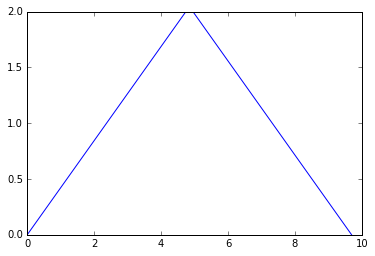

3.0 9.9 6.4


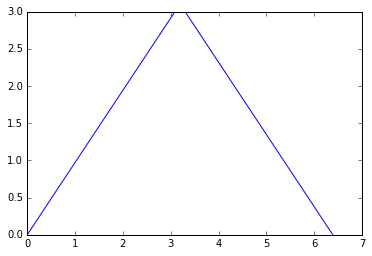

4.0 9.8 4.7


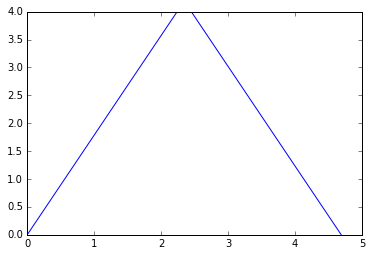

5.0 9.75 3.7


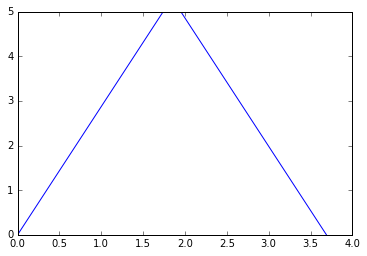

6.0 9.9 3.1


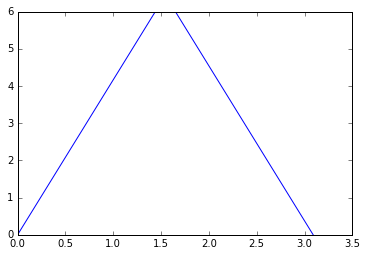

7.0 9.8 2.6


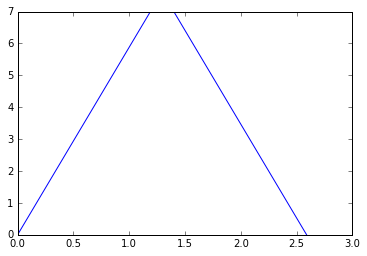

8.0 9.6 2.2


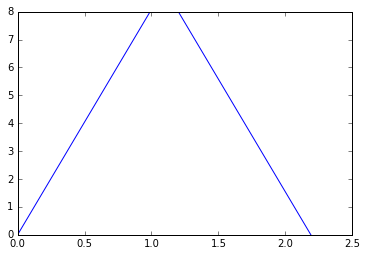

9.0 9.9 2.0


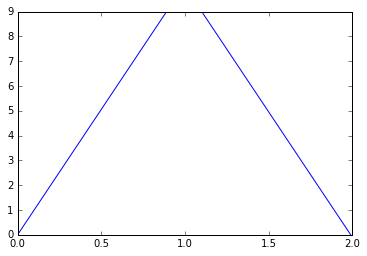

10.0 9.5 1.7


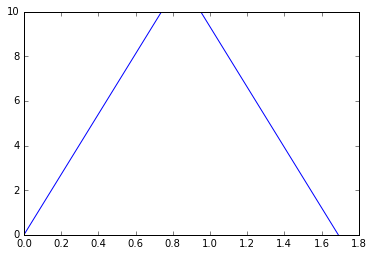

11.0 9.9 1.6


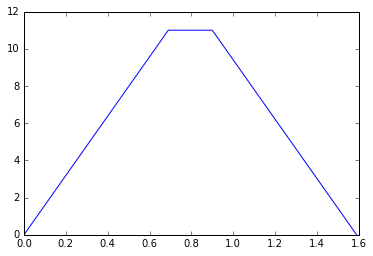

In [26]:
for i,PEF in enumerate([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0]):
    create_custom_wf(PEF,'Custom%02d'%(i+6))

In [27]:
def create_custom_wf_rise(data,name):
    import numpy as np
    from matplotlib import pyplot as plt
    %matplotlib inline
    
    PEF = data[0]
    rise = data[1]
    fs = 200
    with open('%s.wf'%(name),'w') as f:
        f.write('[Header]\n')
        f.write('Group=OpenSpiro\nName=%s\nType=FT\nFreq=%d\nExpStart=0\n\n'%((name,fs)))
        
        FVC = 20
        numpoints = 500
        while FVC >= 10:
            numpoints = numpoints-5
            data = np.linspace(0,PEF,int(PEF/rise*fs) + 1)
            data = np.hstack((data,np.ones((numpoints))*PEF,data[::-1]))
            FVC = np.sum(data/float(fs))
            
        f.write('[Parameters]\nPEF=%.4f\nFVC=%.4f\n\n[Data]\n'%((PEF,FVC)))
        for num in data:
            f.write('%.4f\n'%(num))
    print PEF, FVC, len(data)/float(fs)
    plt.plot(np.array(range(len(data)))/float(fs),data)
    plt.show()

5.0 9.925 2.045


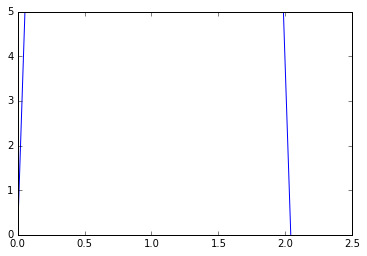

5.0 9.875 2.05


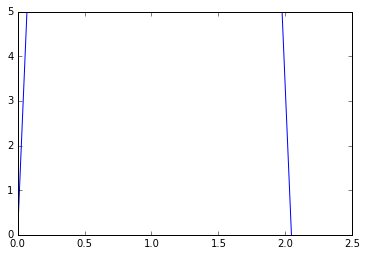

5.0 9.9 2.085


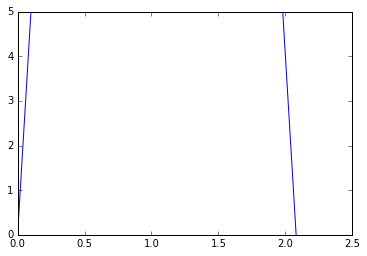

5.0 9.975 2.165


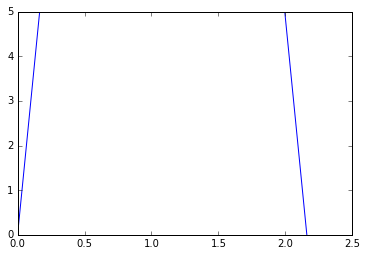

5.0 9.9 2.485


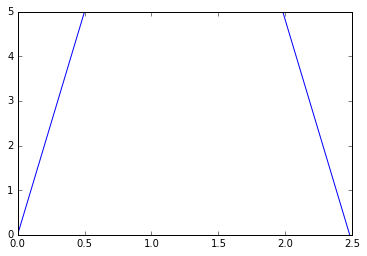

In [28]:
for i,data in enumerate([(5.0,90.0),(5.0,70.0),(5.0,50.0),(5.0,30.0),(5.0,10.0)]):
    create_custom_wf_rise(data,'Custom%02d'%(i+1))

In [29]:
import os
import pandas as pd
dir = "Results3D"
dfs = []
for file in os.listdir(dir):
    if file.endswith(".csv"):
        tmp = pd.read_csv(dir+'/'+file)
        dfs += [tmp]

In [30]:
df = pd.concat(dfs)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66620 entries, 0 to 4322
Data columns (total 8 columns):
Unnamed: 0    66620 non-null int64
flow          66620 non-null float64
volume        66620 non-null float64
vortex        66620 non-null float64
side_f        66620 non-null float64
side_h1       66620 non-null float64
PWG           66620 non-null object
meta          66620 non-null object
dtypes: float64(5), int64(1), object(2)
memory usage: 4.6+ MB


In [31]:
df_pwg = df.groupby('meta')

df_pwg.apply(lambda grp: grp['flow'].count())

meta
Mouthpiece C (Yellow) - Downstream B (Green) - Sidestack C (Yellow)        13303
Mouthpiece D (Red - Closed) - Downstream C (Yellow) - Sidestack A (Red)    53317
dtype: int64

In [32]:
df_c = df[df.meta=='Mouthpiece C (Yellow) - Downstream B (Green) - Sidestack C (Yellow)']
df_m = df[df.meta=='Mouthpiece D (Red - Closed) - Downstream C (Yellow) - Sidestack A (Red)']

/Library/Python/2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


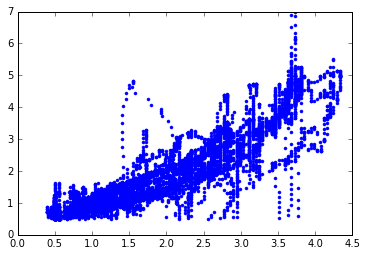

In [33]:
X = df_m[['vortex','side_f','side_h1']].values
y = df_m.flow.values

from sklearn import linear_model as lm

reg = lm.LinearRegression()
th = 0.5
yhat = reg.fit(X[y>th],y[y>th]).predict(X)

plt.plot(yhat[y>th],y[y>th],'.')

/Library/Python/2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


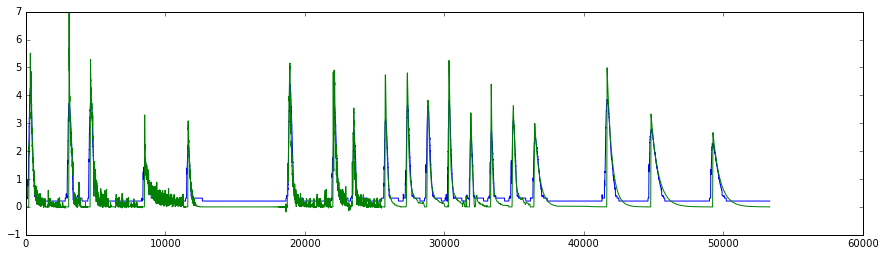

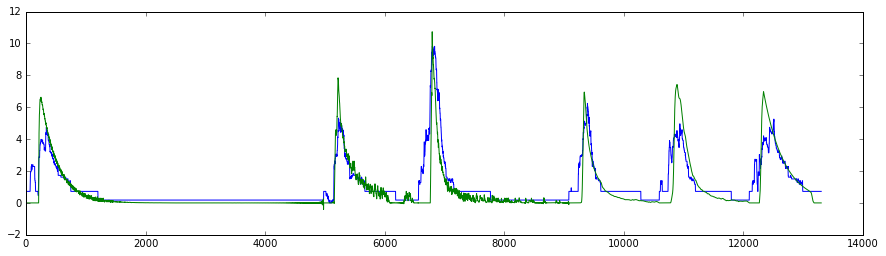

In [56]:
df['flow.pred'] = 0
for meta in ['Mouthpiece D (Red - Closed) - Downstream C (Yellow) - Sidestack A (Red)','Mouthpiece C (Yellow) - Downstream B (Green) - Sidestack C (Yellow)']:
    df_tmp = df[df.meta==meta]

    X = df_tmp[['vortex','side_f','side_h1']].values
    y = df_tmp.flow.values

    from sklearn import linear_model as lm

    reg = lm.LinearRegression()
    th = 0.1
    yhat = np.zeros(y.shape)
    yhat = reg.fit(X[y>th],y[y>th]).predict(X)
    yhat[yhat<0]=0

    f = plt.figure(figsize=(15,4))
    plt.plot(yhat)
    plt.plot(y)

    df_tmp['flow.pred'] = yhat
    df[df.meta==meta] = df_tmp     

plt.show()

In [145]:
# def calc_pef(f):
#     pef = np.max(medfilt(f))
#     return pef
# tmp = df_pwg.apply(lambda grp: calc_pef(grp['flow.pred'].values.astype(np.float)))
# tmp


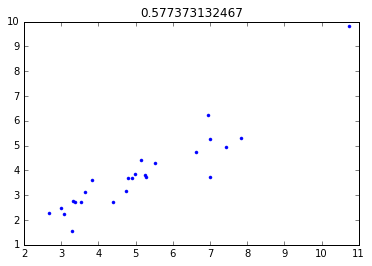

In [115]:
df_pwg = df.groupby('PWG')
tmp = df_pwg.apply(lambda grp: grp[['flow','flow.pred']].max())
plt.plot(tmp['flow'],tmp['flow.pred'],'.')
tmp['flow.pred'] = tmp['flow.pred']+1.2
plt.title(np.mean(np.abs(tmp['flow']-tmp['flow.pred'])))
tmp.to_csv('PEFResults.csv')

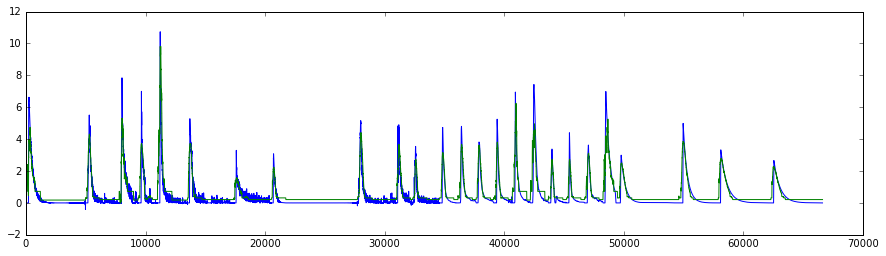

In [60]:
f = plt.figure(figsize=(15,4))
plt.plot(df['flow'].values)
plt.plot(df['flow.pred'].values)

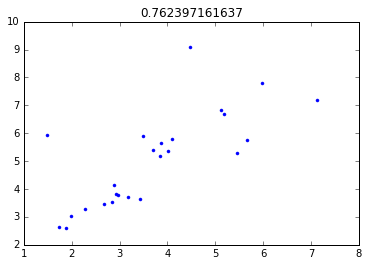

In [116]:
def calc_fvc(f):
    v = np.cumsum(f/fs_effective)
    return np.max(v)

def pd_fvc(grp):
    v1 = calc_fvc(grp['flow'])
    v2 = calc_fvc(medfilt(grp['flow.pred'].values,kernel_size=51))
    return pd.DataFrame(np.array([v1,v2]).reshape((1,2)),columns=['fvc','fvc.pred'])

df_pwg = df.groupby('PWG')
tmp = df_pwg.apply(pd_fvc)

plt.plot(tmp['fvc'],tmp['fvc.pred'],'.')
tmp['fvc.pred']= tmp['fvc.pred']-1
plt.title(np.mean(np.abs(tmp['fvc']-tmp['fvc.pred'])))
tmp.to_csv('FVCResults.csv')

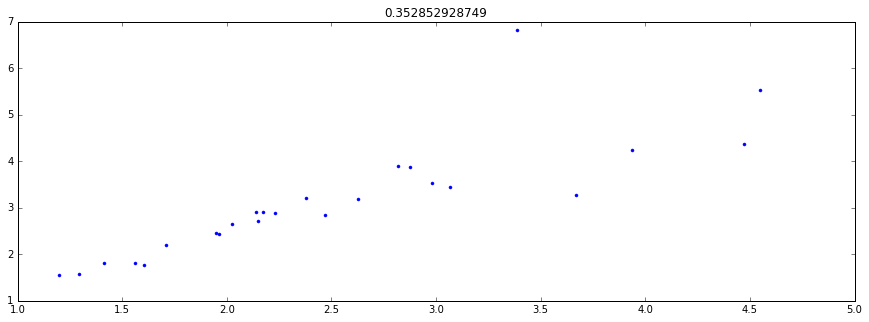

In [184]:
def calc_fvc(f):
    v = np.cumsum(f/fs_effective)
    t = np.array(range(len(v)))/float(fs_effective)
    zero_place = [t[np.argmax(f)-80]]
#     print zero_place[0]
    t = t-zero_place[0]
#     plt.plot(t,v)
    t = t[t<=1.0]
    return v[len(t)]

def pd_fvc(grp):
    v1 = calc_fvc(grp['flow'])
    v2 = calc_fvc(medfilt(grp['flow.pred'].values,kernel_size=51))
    return pd.DataFrame(np.array([v1,v2]).reshape((1,2)),columns=['fev1','fev1.pred'])

plt.figure(figsize=(15,5))
df_pwg = df.groupby('PWG')
tmp = df_pwg.apply(pd_fvc)

plt.plot(tmp['fev1'],tmp['fev1.pred'],'.')
tmp['fev1.pred']= tmp['fev1.pred']-0.5
plt.title(np.mean(np.abs(tmp['fev1']-tmp['fev1.pred'])))
# plt.xlim([0,2])
tmp.to_csv('FEV1Results.csv')

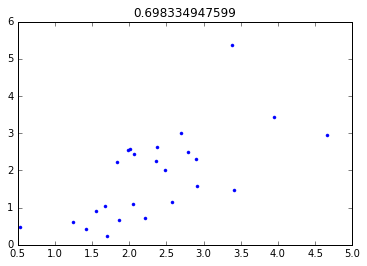

In [144]:
def calc_fvc(f):
    v = np.cumsum(f/fs_effective)
    vmax = np.max(v)
    
    return np.mean(f[(v>0.25*vmax)&(v<0.75*vmax)])

def pd_fvc(grp):
    v1 = calc_fvc(grp['flow'])
    v2 = calc_fvc(medfilt(grp['flow.pred'].values,kernel_size=51))
    return pd.DataFrame(np.array([v1,v2]).reshape((1,2)),columns=['fef','fef.pred'])

df_pwg = df.groupby('PWG')
tmp = df_pwg.apply(pd_fvc)

plt.plot(tmp['fef'],tmp['fef.pred'],'.')
tmp['fef.pred']= tmp['fef.pred']+0.5
plt.title(np.mean(np.abs(tmp['fef']-tmp['fef.pred'])))
tmp.to_csv('FEF2575Results.csv')

# Digi-Doc


In [186]:
import os
import pandas as pd
dir = "ResultsDigi"
dfs = []
for file in os.listdir(dir):
    if file.endswith(".csv"):
        tmp = pd.read_csv(dir+'/'+file)
        dfs += [tmp]
        
df = pd.concat(dfs)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67536 entries, 0 to 4305
Data columns (total 8 columns):
Unnamed: 0    67536 non-null int64
flow          67536 non-null float64
volume        67536 non-null float64
vortex        67536 non-null float64
side_f        67536 non-null float64
side_h1       67536 non-null float64
PWG           67536 non-null object
meta          67536 non-null object
dtypes: float64(5), int64(1), object(2)
memory usage: 4.6+ MB


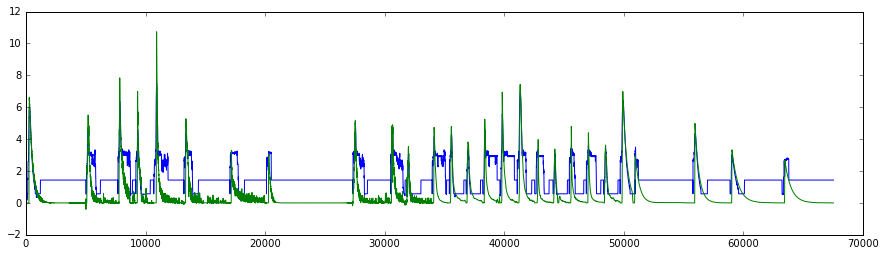

In [188]:
df_tmp = df

X = df_tmp[['vortex','side_f','side_h1']].values
y = df_tmp.flow.values

from sklearn import linear_model as lm

reg = lm.LinearRegression()
th = 2
yhat = np.zeros(y.shape)
yhat = reg.fit(X[y>th],y[y>th]).predict(X)
yhat[yhat<0]=0

f = plt.figure(figsize=(15,4))
plt.plot(yhat)
plt.plot(y)

df_tmp['flow.pred'] = yhat
df =df_tmp

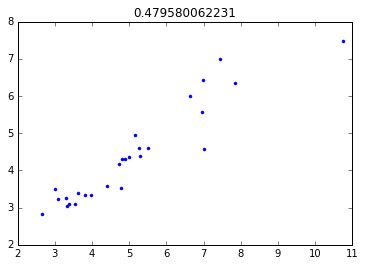

In [197]:
df_pwg = df.groupby('PWG')
tmp = df_pwg.apply(lambda grp: grp[['flow','flow.pred']].max())
plt.plot(tmp['flow'],tmp['flow.pred'],'.')
tmp['flow.pred'] = tmp['flow.pred']+0.6
plt.title(np.mean(np.abs(tmp['flow']-tmp['flow.pred'])))
tmp.to_csv('Digi_PEFResults.csv')

In [209]:
dfres = pd.read_csv("PWG Testing - Results_Person.csv")
dfres['digi%'] = (dfres['digi.flow']-dfres['digi.flow.pred'])/dfres['digi.flow']
dfres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27 entries, 0 to 26
Data columns (total 28 columns):
digi.flow         27 non-null float64
Residual          27 non-null float64
digi.flow.pred    27 non-null float64
PEF               25 non-null float64
Residual.1        25 non-null float64
PEF.pred          25 non-null float64
PEF.diff          25 non-null float64
PEF.diff%         25 non-null float64
fef2575           25 non-null float64
Residual.2        25 non-null float64
fef2575.pred      25 non-null float64
fef2575.diff      25 non-null float64
fefe2575.diff%    25 non-null float64
fev1              25 non-null float64
Residual.3        25 non-null float64
fev1.pred         25 non-null float64
fev1.diff         25 non-null float64
fev.diff%         25 non-null float64
fvc               25 non-null float64
Residual.4        25 non-null float64
fvc.pred          25 non-null float64
fvc.diff          25 non-null float64
fvc.diff%         25 non-null float64
fev1%             25 no

In [223]:
dftmp = dfres[['Residual','Residual.1','Residual.2','Residual.3','Residual.4','Residual.5']]
dftmp = dfres[['digi%','PEF.diff%','fefe2575.diff%','fev.diff%','fvc.diff%','fev1%.diff']]*100

/Library/Python/2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


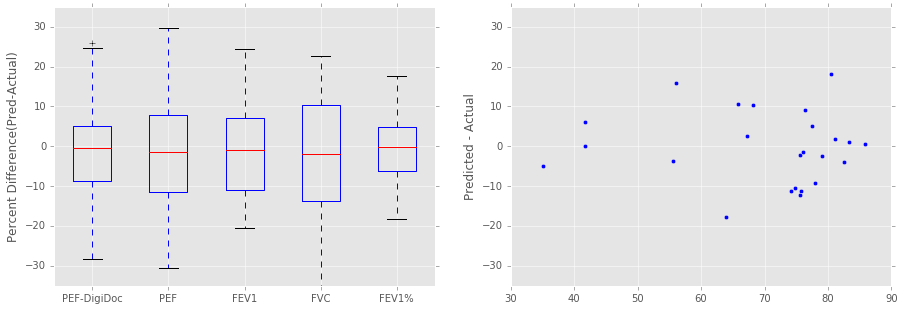

In [228]:
plt.style.use('ggplot')
plt.figure(figsize=(15,5))
dftmp.columns = ['PEF-DigiDoc','PEF', 'FEF2575','FEV1','FVC','FEV1%']

plt.subplot(121)
dftmp[['PEF-DigiDoc','PEF','FEV1','FVC','FEV1%']].boxplot()
plt.ylim([-35,35])
plt.ylabel('Percent Difference(Pred-Actual)')

plt.subplot(122)
plt.scatter(dfres['fev1%']*100,dfres['Residual.5']*100)
plt.ylim([-35,35])
plt.ylabel('Predicted - Actual')
plt.show()